In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
import torch.optim as optim
from timm.layers import DropPath
import matplotlib.pyplot as plt




import torch


device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Hyperparameters

# device       = 'cuda' if torch.cuda.is_available() else 'cpu'
patch_size   = 4
latent_size  = 384
n_channels   = 3
num_heads    = 6
num_layers   = 6
dropout      = 0.1
num_classes  = 10
size         = 32
epochs       = 200
base_lr      = 1e-3
weight_decay = 0.1
batch_size   = 128


torch.manual_seed(0)
print(f"Using device: {device}")

import torch
import torch.nn.functional as F

def cutmix(images, labels, alpha=1.0):
    """Applies CutMix augmentation on a batch."""
    B, C, H, W = images.size()
    # Sample mixing coefficient
    lam = np.random.beta(alpha, alpha) if alpha > 0 else 1.0
    # Generate random bounding box
    rx = np.random.randint(W)
    ry = np.random.randint(H)
    rw = int(W * np.sqrt(1 - lam))
    rh = int(H * np.sqrt(1 - lam))
    x1 = np.clip(rx - rw // 2, 0, W)
    y1 = np.clip(ry - rh // 2, 0, H)
    x2 = np.clip(rx + rw // 2, 0, W)
    y2 = np.clip(ry + rh // 2, 0, H)
    # Shuffle batch and apply box
    perm = torch.randperm(B).to(images.device)
    images_cut = images.clone()
    images_cut[:, :, y1:y2, x1:x2] = images[perm, :, y1:y2, x1:x2]
    # Adjust lambda to exactly match pixel ratio
    lam_adjusted = 1 - ((x2 - x1) * (y2 - y1) / (W * H))
    labels_a, labels_b = labels, labels[perm]
    return images_cut, labels_a, labels_b, lam_adjusted


def mixup_data(x, y, alpha=0.4):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.0
    B = x.size(0)
    index = torch.randperm(B).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def rand_augmented_batch(images, labels, alpha=0.4, cutmix_prob=0.5):
    if np.random.rand() < cutmix_prob:
        images, labels_a, labels_b, lam = cutmix(images, labels, alpha)  # you need to implement or import cutmix
    else:
        images, labels_a, labels_b, lam = mixup_data(images, labels, alpha)
    return images, labels_a, labels_b, lam
 



# 1. Multi-Head Attention components
class HeadNormal(nn.Module):
    def __init__(self, latent_size, num_heads, dropout):
        super().__init__()
        head_size = latent_size // num_heads
        self.key   = nn.Linear(latent_size, head_size, bias=False)
        self.query = nn.Linear(latent_size, head_size, bias=False)
        self.value = nn.Linear(latent_size, head_size, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        k = self.key(x)    # (B, T, head_size)
        q = self.query(x)  # (B, T, head_size)
        v = self.value(x)  # (B, T, head_size)
        scores = (q @ k.transpose(-2, -1)) * (k.shape[-1] ** -0.5)
        weights = F.softmax(scores, dim=-1)
        weights = self.dropout(weights)
        out = weights @ v
        return out


class MultiHeadAttention(nn.Module):
    def __init__(self, latent_size, num_heads, dropout):
        super().__init__()
        self.heads = nn.ModuleList([
            HeadNormal(latent_size, num_heads, dropout)
            for _ in range(num_heads)
        ])
        self.proj = nn.Linear((latent_size // num_heads) * num_heads, latent_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.proj(out)
        out = self.dropout(out)
        return out


# 2. Input Embedding
class InputEmbedding(nn.Module):
    def __init__(self, patch_size, n_channels, latent_size):
        super().__init__()
        self.patcher = nn.Conv2d(
            in_channels=n_channels,
            out_channels=latent_size,
            kernel_size=patch_size,
            stride=patch_size
        )
        self.flatten = nn.Flatten(start_dim=2, end_dim=3)
        self.class_token = nn.Parameter(torch.randn(1, 1, latent_size))
        num_patches = (size // patch_size) ** 2
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, latent_size))

    def forward(self, x):
        B = x.size(0)
        x = self.patcher(x)              # (B, latent_size, P, P)
        x = self.flatten(x)              # (B, latent_size, num_patches)
        x = x.permute(0, 2, 1)           # (B, num_patches, latent_size)
        cls = self.class_token.expand(B, -1, -1)
        x = torch.cat([cls, x], dim=1)   # (B, num_patches+1, latent_size)
        x = x + self.pos_embedding
        return x


# 3. Encoder Block
# EncoderBlock remains mostly the same, just ensure drop_path_rate input is used
class EncoderBlock(nn.Module):
    def __init__(self, latent_size, num_heads, dropout, drop_path_rate=0.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(latent_size)
        self.mha   = MultiHeadAttention(latent_size, num_heads, dropout)
        self.drop_path1 = DropPath(drop_path_rate)  # Use passed rate
        self.norm2 = nn.LayerNorm(latent_size)
        self.mlp   = nn.Sequential(
            nn.Linear(latent_size, latent_size * 4),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(latent_size * 4, latent_size),
            nn.Dropout(dropout)
        )
        self.drop_path2 = DropPath(drop_path_rate)

    def forward(self, x):
        res = x
        x = self.norm1(x)
        x = self.mha(x)
        x = res + self.drop_path1(x)

        res = x
        x = self.norm2(x)
        x = self.mlp(x)
        x = res + self.drop_path2(x)
        return x




# 4. ViT Model
class VitModel(nn.Module):
    def __init__(self, num_encoders, latent_size, num_heads, num_classes, dropout):
        super().__init__()
        self.embd = InputEmbedding(patch_size, n_channels, latent_size)
        drop_path_rates = [x.item() for x in torch.linspace(0, 0.3, num_encoders)]
        self.encoders = nn.ModuleList([
            EncoderBlock(latent_size, num_heads, dropout, drop_path_rate=dp)
            for dp in drop_path_rates
        ])
        self.norm = nn.LayerNorm(latent_size)
        self.head = nn.Sequential(
            nn.Linear(latent_size, latent_size // 2),
            nn.GELU(),
            nn.Dropout(0.2),
            nn.Linear(latent_size // 2, num_classes)
        )

    def forward(self, x):
        x = self.embd(x)
        for enc in self.encoders:
            x = enc(x)
        cls = x[:, 0]
        cls = self.norm(cls)
        logits = self.head(cls)
        return logits



# 5. Data loading & training loop with progress bars




Using device: cuda


In [5]:
if __name__ == "__main__":
    # Transforms and loaders

    train_losses = []
    val_losses = []
    val_accuracies = []
    transform_train = transforms.Compose([
        transforms.RandomCrop(size, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.RandAugment(num_ops=2, magnitude=9),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                            (0.2023, 0.1994, 0.2010)),
    ])

    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914,0.4822,0.4465),
                             (0.2023,0.1994,0.2010))
    ])
    trainloader = DataLoader(
        CIFAR10(root='./data', train=True, download=True, transform=transform_train),
        batch_size=batch_size, shuffle=True, num_workers=2
    )
    testloader = DataLoader(
        CIFAR10(root='./data', train=False, download=True, transform=transform_test),
        batch_size=batch_size, shuffle=False, num_workers=2
    )

    # Model, loss, optimizer, scheduler
    model = VitModel(num_layers, latent_size, num_heads, num_classes, dropout).to(device)

    decay, no_decay = [], []
    for name, param in model.named_parameters():
        if param.ndim > 1:
            decay.append(param)
        else:
            no_decay.append(param)
    optimizer = optim.AdamW([
        {'params': decay,    'weight_decay': weight_decay},
        {'params': no_decay, 'weight_decay': 0.0}
    ], lr=base_lr)

    # Setup LR scheduler
    total_steps = epochs * len(trainloader)
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer, max_lr=base_lr, total_steps=total_steps,
        pct_start=0.1, anneal_strategy='cos', final_div_factor=1e4
    )
    
    criterion = nn.CrossEntropyLoss(label_smoothing=0.15)
    # optimizer = optim.AdamW(model.parameters(), lr=base_lr, weight_decay=weight_decay)
    # scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    for epoch in range(1, epochs + 1):
        model.train()
        train_bar = tqdm(trainloader, desc=f"Epoch {epoch}/{epochs} [Train]", leave=False)
        total_loss = 0
        for images, labels in train_bar:
            images, labels = images.to(device), labels.to(device)
            images, targets_a, targets_b, lam = rand_augmented_batch(images, labels, alpha=0.4, cutmix_prob=0.5)



            optimizer.zero_grad()
            outputs = model(images)
            loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)
            loss.backward()
            optimizer.step()
            scheduler.step()

            total_loss += loss.item()
            train_bar.set_postfix(loss=f"{loss.item():.4f}")

        avg_train_loss = total_loss / len(trainloader)
        model.eval()
        val_bar = tqdm(testloader, desc=f"Epoch {epoch}/{epochs} [Val]", leave=False)
        correct, total, val_loss = 0, 0, 0
        for images, labels in val_bar:
            images, labels = images.to(device), labels.to(device)
            with torch.no_grad():
                outputs = model(images)
                loss = criterion(outputs, labels)
            val_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            val_bar.set_postfix(loss=f"{loss.item():.4f}", acc=f"{100*correct/total:.2f}%")
        avg_val_loss = val_loss / len(testloader)
        val_acc = 100 * correct / total

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_acc)
        print(f"Epoch {epoch} Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.2f}%\n")

Epoch 1 Val Loss: 1.9903 | Val Acc: 32.14%



Epoch 2 Val Loss: 1.8758 | Val Acc: 38.15%



Epoch 3 Val Loss: 1.8067 | Val Acc: 43.02%



Epoch 4 Val Loss: 1.7088 | Val Acc: 49.41%



Epoch 5 Val Loss: 1.6871 | Val Acc: 49.98%



Epoch 6 Val Loss: 1.6746 | Val Acc: 49.77%



Epoch 7 Val Loss: 1.6814 | Val Acc: 47.79%



Epoch 8 Val Loss: 1.6586 | Val Acc: 52.23%



Epoch 9 Val Loss: 1.6069 | Val Acc: 53.84%



Epoch 10 Val Loss: 1.6410 | Val Acc: 51.78%



Epoch 11 Val Loss: 1.6821 | Val Acc: 50.79%



Epoch 12 Val Loss: 1.6198 | Val Acc: 53.15%



Epoch 13 Val Loss: 1.6345 | Val Acc: 52.05%



Epoch 14 Val Loss: 1.6566 | Val Acc: 51.96%



Epoch 15 Val Loss: 1.6541 | Val Acc: 50.49%



Epoch 16 Val Loss: 1.6015 | Val Acc: 55.64%



Epoch 17 Val Loss: 1.6391 | Val Acc: 52.60%



Epoch 18 Val Loss: 1.6250 | Val Acc: 52.19%



Epoch 19 Val Loss: 1.5371 | Val Acc: 57.62%



Epoch 20 Val Loss: 1.5381 | Val Acc: 57.86%



Epoch 21 Val Loss: 1.5016 | Val Acc: 59.95%



Epoch 22 Val Loss: 1.5146 | Val Acc: 59.53%



Epoch 23 Val Loss: 1.4613 | Val Acc: 63.28%



Epoch 24 Val Loss: 1.4589 | Val Acc: 62.37%



Epoch 25 Val Loss: 1.4197 | Val Acc: 64.64%



Epoch 26 Val Loss: 1.4212 | Val Acc: 63.93%



Epoch 27 Val Loss: 1.3946 | Val Acc: 64.11%



Epoch 28 Val Loss: 1.3906 | Val Acc: 66.77%



Epoch 29 Val Loss: 1.3739 | Val Acc: 66.09%



Epoch 30 Val Loss: 1.3828 | Val Acc: 67.09%



Epoch 31 Val Loss: 1.4084 | Val Acc: 68.25%



Epoch 32 Val Loss: 1.3556 | Val Acc: 66.62%



Epoch 33 Val Loss: 1.3366 | Val Acc: 68.39%



Epoch 34 Val Loss: 1.3209 | Val Acc: 69.69%



Epoch 35 Val Loss: 1.3261 | Val Acc: 68.01%



Epoch 36 Val Loss: 1.2951 | Val Acc: 69.98%



Epoch 37 Val Loss: 1.2888 | Val Acc: 72.01%



Epoch 38 Val Loss: 1.3162 | Val Acc: 70.73%



Epoch 39 Val Loss: 1.3297 | Val Acc: 68.70%



Epoch 40 Val Loss: 1.2573 | Val Acc: 73.48%



Epoch 41 Val Loss: 1.2769 | Val Acc: 70.54%



Epoch 42 Val Loss: 1.2447 | Val Acc: 73.33%



Epoch 43 Val Loss: 1.2562 | Val Acc: 73.29%



Epoch 44 Val Loss: 1.2568 | Val Acc: 73.33%



Epoch 45 Val Loss: 1.2113 | Val Acc: 75.20%



Epoch 46 Val Loss: 1.2564 | Val Acc: 74.00%



Epoch 47 Val Loss: 1.2908 | Val Acc: 71.90%



Epoch 48 Val Loss: 1.2046 | Val Acc: 75.13%



Epoch 49 Val Loss: 1.2448 | Val Acc: 74.73%



Epoch 50 Val Loss: 1.2206 | Val Acc: 74.72%



Epoch 51 Val Loss: 1.1931 | Val Acc: 76.02%



Epoch 52 Val Loss: 1.2135 | Val Acc: 75.21%



Epoch 53 Val Loss: 1.2065 | Val Acc: 75.52%



Epoch 54 Val Loss: 1.2093 | Val Acc: 74.82%



Epoch 55 Val Loss: 1.1982 | Val Acc: 74.69%



Epoch 56 Val Loss: 1.1687 | Val Acc: 77.43%



Epoch 57 Val Loss: 1.2100 | Val Acc: 75.96%



Epoch 58 Val Loss: 1.1987 | Val Acc: 75.95%



Epoch 59 Val Loss: 1.1763 | Val Acc: 76.94%



Epoch 60 Val Loss: 1.1752 | Val Acc: 77.57%



Epoch 61 Val Loss: 1.1920 | Val Acc: 76.43%



Epoch 62 Val Loss: 1.1880 | Val Acc: 76.84%



Epoch 63 Val Loss: 1.1974 | Val Acc: 75.78%



Epoch 64 Val Loss: 1.1633 | Val Acc: 77.56%



Epoch 65 Val Loss: 1.1538 | Val Acc: 77.73%



Epoch 66 Val Loss: 1.1479 | Val Acc: 78.28%



Epoch 67 Val Loss: 1.1265 | Val Acc: 79.21%



Epoch 68 Val Loss: 1.1586 | Val Acc: 77.68%



Epoch 69 Val Loss: 1.1511 | Val Acc: 77.92%



Epoch 70 Val Loss: 1.1470 | Val Acc: 79.79%



Epoch 71 Val Loss: 1.1105 | Val Acc: 79.38%



Epoch 72 Val Loss: 1.1658 | Val Acc: 77.34%



Epoch 73 Val Loss: 1.1100 | Val Acc: 79.71%



Epoch 74 Val Loss: 1.1372 | Val Acc: 78.52%



Epoch 75 Val Loss: 1.1481 | Val Acc: 78.36%



Epoch 76 Val Loss: 1.1321 | Val Acc: 78.57%



Epoch 77 Val Loss: 1.1128 | Val Acc: 79.92%



Epoch 78 Val Loss: 1.1276 | Val Acc: 79.06%



Epoch 79 Val Loss: 1.0973 | Val Acc: 80.45%



Epoch 80 Val Loss: 1.1252 | Val Acc: 79.76%



Epoch 81 Val Loss: 1.1156 | Val Acc: 79.39%



Epoch 82 Val Loss: 1.0910 | Val Acc: 80.70%



Epoch 83 Val Loss: 1.0983 | Val Acc: 80.33%



Epoch 84 Val Loss: 1.0864 | Val Acc: 80.95%



Epoch 85 Val Loss: 1.1040 | Val Acc: 81.01%



Epoch 86 Val Loss: 1.1023 | Val Acc: 80.72%



Epoch 87 Val Loss: 1.0914 | Val Acc: 81.43%



Epoch 88 Val Loss: 1.0934 | Val Acc: 80.88%



Epoch 89 Val Loss: 1.0868 | Val Acc: 81.29%



Epoch 90 Val Loss: 1.0853 | Val Acc: 80.98%



Epoch 91 Val Loss: 1.0936 | Val Acc: 80.63%



Epoch 92 Val Loss: 1.0771 | Val Acc: 81.40%



Epoch 93 Val Loss: 1.0692 | Val Acc: 81.98%



Epoch 94 Val Loss: 1.0622 | Val Acc: 82.60%



Epoch 95 Val Loss: 1.0587 | Val Acc: 82.69%



Epoch 96 Val Loss: 1.0977 | Val Acc: 80.26%



Epoch 97 Val Loss: 1.0880 | Val Acc: 80.62%



Epoch 98 Val Loss: 1.0724 | Val Acc: 82.11%



Epoch 99 Val Loss: 1.0716 | Val Acc: 82.73%



Epoch 100 Val Loss: 1.0640 | Val Acc: 81.88%



Epoch 101 Val Loss: 1.0697 | Val Acc: 82.63%



Epoch 102 Val Loss: 1.0556 | Val Acc: 82.89%



Epoch 103 Val Loss: 1.0517 | Val Acc: 83.22%



Epoch 104 Val Loss: 1.0496 | Val Acc: 83.51%



Epoch 105 Val Loss: 1.0506 | Val Acc: 82.42%



Epoch 106 Val Loss: 1.0392 | Val Acc: 83.21%



Epoch 107 Val Loss: 1.0521 | Val Acc: 82.53%



Epoch 108 Val Loss: 1.0404 | Val Acc: 83.51%



Epoch 109 Val Loss: 1.0383 | Val Acc: 83.40%



Epoch 110 Val Loss: 1.0198 | Val Acc: 84.01%



Epoch 111 Val Loss: 1.0299 | Val Acc: 83.27%



Epoch 112 Val Loss: 1.0246 | Val Acc: 84.11%



Epoch 113 Val Loss: 1.0024 | Val Acc: 85.21%



Epoch 114 Val Loss: 1.0157 | Val Acc: 84.76%



Epoch 115 Val Loss: 1.0107 | Val Acc: 84.38%



Epoch 116 Val Loss: 1.0106 | Val Acc: 84.95%



Epoch 117 Val Loss: 1.0249 | Val Acc: 84.14%



Epoch 118 Val Loss: 0.9945 | Val Acc: 85.67%



Epoch 119 Val Loss: 0.9963 | Val Acc: 85.47%



Epoch 120 Val Loss: 1.0055 | Val Acc: 85.26%



Epoch 121 Val Loss: 1.0042 | Val Acc: 85.20%



Epoch 122 Val Loss: 0.9922 | Val Acc: 85.69%



Epoch 123 Val Loss: 0.9804 | Val Acc: 86.05%



Epoch 124 Val Loss: 0.9780 | Val Acc: 86.44%



Epoch 125 Val Loss: 0.9905 | Val Acc: 85.87%



Epoch 126 Val Loss: 0.9844 | Val Acc: 85.80%



Epoch 127 Val Loss: 1.0005 | Val Acc: 85.80%



Epoch 128 Val Loss: 0.9771 | Val Acc: 86.28%



Epoch 129 Val Loss: 0.9953 | Val Acc: 85.52%



Epoch 130 Val Loss: 0.9752 | Val Acc: 86.39%



Epoch 131 Val Loss: 0.9689 | Val Acc: 86.55%



Epoch 132 Val Loss: 0.9715 | Val Acc: 86.28%



Epoch 133 Val Loss: 0.9617 | Val Acc: 86.87%



Epoch 134 Val Loss: 0.9678 | Val Acc: 86.84%



Epoch 135 Val Loss: 0.9615 | Val Acc: 86.51%



Epoch 136 Val Loss: 0.9584 | Val Acc: 87.07%



Epoch 137 Val Loss: 0.9669 | Val Acc: 87.21%



Epoch 138 Val Loss: 0.9626 | Val Acc: 86.99%



Epoch 139 Val Loss: 0.9591 | Val Acc: 87.04%



Epoch 140 Val Loss: 0.9639 | Val Acc: 87.20%



Epoch 141 Val Loss: 0.9524 | Val Acc: 87.61%



Epoch 142 Val Loss: 0.9714 | Val Acc: 87.01%



Epoch 143 Val Loss: 0.9494 | Val Acc: 88.13%



Epoch 144 Val Loss: 0.9604 | Val Acc: 87.49%



Epoch 145 Val Loss: 0.9424 | Val Acc: 87.87%



Epoch 146 Val Loss: 0.9494 | Val Acc: 87.52%



Epoch 147 Val Loss: 0.9446 | Val Acc: 87.86%



Epoch 148 Val Loss: 0.9352 | Val Acc: 88.35%



Epoch 149 Val Loss: 0.9347 | Val Acc: 88.50%



Epoch 150 Val Loss: 0.9314 | Val Acc: 88.39%



Epoch 151 Val Loss: 0.9276 | Val Acc: 88.86%



Epoch 152 Val Loss: 0.9350 | Val Acc: 88.36%



Epoch 153 Val Loss: 0.9335 | Val Acc: 88.59%



Epoch 154 Val Loss: 0.9269 | Val Acc: 88.94%



Epoch 155 Val Loss: 0.9342 | Val Acc: 88.76%



Epoch 156 Val Loss: 0.9257 | Val Acc: 88.88%



Epoch 157 Val Loss: 0.9270 | Val Acc: 88.69%



Epoch 158 Val Loss: 0.9194 | Val Acc: 89.17%



Epoch 159 Val Loss: 0.9210 | Val Acc: 89.42%



Epoch 160 Val Loss: 0.9222 | Val Acc: 88.95%



Epoch 161 Val Loss: 0.9189 | Val Acc: 89.37%



Epoch 162 Val Loss: 0.9160 | Val Acc: 89.56%



Epoch 163 Val Loss: 0.9191 | Val Acc: 89.69%



Epoch 164 Val Loss: 0.9113 | Val Acc: 89.81%



Epoch 165 Val Loss: 0.9072 | Val Acc: 89.67%



Epoch 166 Val Loss: 0.9062 | Val Acc: 89.73%



Epoch 167 Val Loss: 0.9126 | Val Acc: 89.59%



Epoch 168 Val Loss: 0.9042 | Val Acc: 89.90%



Epoch 169 Val Loss: 0.9081 | Val Acc: 89.74%



Epoch 170 Val Loss: 0.9078 | Val Acc: 89.78%



Epoch 171 Val Loss: 0.9060 | Val Acc: 89.56%



Epoch 172 Val Loss: 0.9039 | Val Acc: 89.92%



Epoch 173 Val Loss: 0.9023 | Val Acc: 89.97%



Epoch 174 Val Loss: 0.9034 | Val Acc: 90.00%



Epoch 175 Val Loss: 0.9010 | Val Acc: 89.89%



Epoch 178 Val Loss: 0.8996 | Val Acc: 90.15%



Epoch 179 Val Loss: 0.8995 | Val Acc: 90.12%



Epoch 180 Val Loss: 0.9010 | Val Acc: 89.97%



Epoch 181 Val Loss: 0.8961 | Val Acc: 90.29%



Epoch 182 Val Loss: 0.8964 | Val Acc: 90.26%



Epoch 183 Val Loss: 0.8977 | Val Acc: 90.16%



Epoch 184 Val Loss: 0.8969 | Val Acc: 90.20%



Epoch 185 Val Loss: 0.8968 | Val Acc: 90.31%



Epoch 186 Val Loss: 0.8972 | Val Acc: 90.20%



Epoch 187 Val Loss: 0.8953 | Val Acc: 90.52%



Epoch 188 Val Loss: 0.8948 | Val Acc: 90.37%



Epoch 189 Val Loss: 0.8954 | Val Acc: 90.36%



Epoch 190 Val Loss: 0.8939 | Val Acc: 90.63%



Epoch 191 Val Loss: 0.8937 | Val Acc: 90.49%



Epoch 192 Val Loss: 0.8932 | Val Acc: 90.53%



Epoch 193 Val Loss: 0.8925 | Val Acc: 90.40%



Epoch 194 Val Loss: 0.8923 | Val Acc: 90.45%



Epoch 195 Val Loss: 0.8921 | Val Acc: 90.48%



Epoch 196 Val Loss: 0.8920 | Val Acc: 90.54%



Epoch 197 Val Loss: 0.8919 | Val Acc: 90.48%



Epoch 198 Val Loss: 0.8923 | Val Acc: 90.49%



Epoch 199 Val Loss: 0.8923 | Val Acc: 90.51%



Epoch 200 Val Loss: 0.8923 | Val Acc: 90.51%



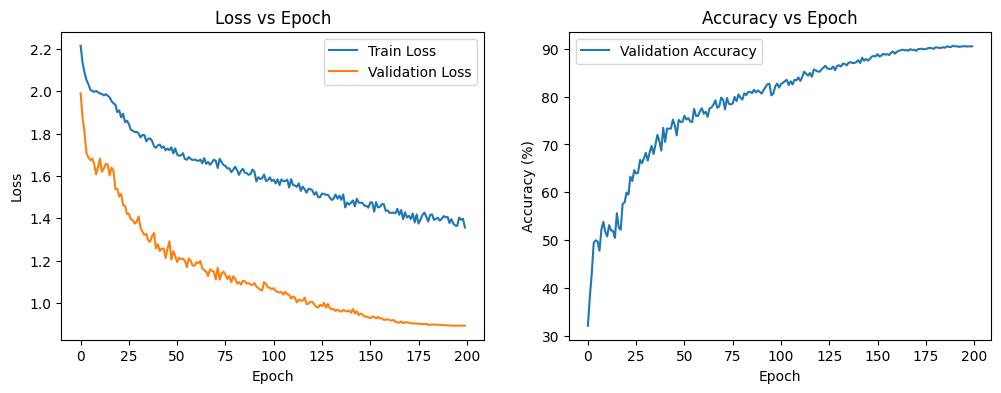

In [6]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Epoch')
plt.legend()
plt.show()